In [1]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import geone.geosclassicinterface as gci
import pyvista as pv
import sys
import scipy
from skimage.measure import label  # for connectivity

import shapely
from shapely.geometry import Polygon, LineString, MultiPolygon, MultiLineString
import rasterio
import rasterio.features
from rasterio import Affine

import EROS

%load_ext autoreload
%autoreload 2

In [3]:

def plot_bhs(w_logs, z0, plotter=None, v_ex=1):

    """
    Plot boreholes in w_logs

    #parameters#
    w_logs   : string, which log to plot --> strati or facies
    plotter: pyvista plotter
    v_ex  : float, vertical exaggeration
    """

    def lines_from_points(points):
        """Given an array of points, make a line set"""
        poly=pv.PolyData()
        poly.points=points
        cells=np.full((len(points)-1, 3), 2, dtype=np.int_)
        cells[:, 1]=np.arange(0, len(points)-1, dtype=np.int_)
        cells[:, 2]=np.arange(1, len(points), dtype=np.int_)
        poly.lines=cells
        return poly

    if plotter is None:
        p=pv.Plotter()
    else:
        p=plotter

    for bh in w_logs:
        for i in range(len(bh[3])):

            l=[]
            st=bh[3][i][0]
            l.append(bh[3][i][1])
            if i < len(bh[3])-1:
                l.append(bh[3][i+1][1])

            if i == len(bh[3])-1:
                l.append(bh[3][0][1]-bh[2])
            pts=np.array([np.ones([len(l)])*bh[0], np.ones([len(l)])*bh[1], l]).T
           
            line=lines_from_points(pts)
            line.points[:, -1]=(line.points[:, -1] - z0)*v_ex+z0
            if st is not None:
                np.random.seed(st+24)
                color=np.random.random(size=3)
                opacity=1
            else:
                color="white"
                opacity=0
            p.add_mesh(line, color=color, interpolate_before_map=True, render_lines_as_tubes=True, line_width=15, opacity=opacity)

    if plotter is None:
        p.add_bounding_box()
        p.show_axes()
        p.show()

In [31]:
nx = 150
ny = 150
nz = 50
dim = (nx, ny, nz)
sx = 1.5
sy = 1.5
sz = 0.5
spa = (sx, sy, sz)
ox = 0
oy = 0
oz = 0
origin = (ox, oy, oz)
z1 = oz+nz*sz+sz
bot = np.ones((ny, nx))*oz
top = np.ones((ny, nx))*z1

N_surf = 70
xi = 0.2

xgc = np.linspace(ox+sx/2, ox+sx*nx-sx/2, nx)
ygc = np.linspace(oy+sy/2, oy+sy*ny-sy/2, ny)
zg = np.linspace(oz, oz+nz*sz+sz, nz)
means = np.sort(np.random.uniform(zg[0]-5, zg[-1]+5, size = N_surf))


cm = gcm.CovModel2D(elem=[("matern", {"w":20, "r":[40, 100], "nu":2/2})], alpha=42)
cm2 = gcm.CovModel2D(elem=[("spherical", {"w":20, "r":[400, 100]})], alpha=45)
cm_erod = gcm.CovModel2D(elem=[("cubic", {"w":10, "r":[300, 350]})], alpha=40)

In [23]:
# w_logs
w_logs = [(13, 20, 15, [(1, 25), (2, 20), (3, 17), (1, 15)]),
 (25, 40, 10, [(2, 25), (1, 21), (3, 18)]),
 (125, 50, 11, [(2, 25), (1, 21), (3, 16)]),
 (100, 150, 7.5, [(2, 25), (1, 23)]),
 (70, 90, 7.5, [(4, 10), (3, 5)])]

In [6]:
plot_bhs(w_logs, 0)

Widget(value="<iframe src='http://localhost:64794/index.html?ui=P_0x22df2de5f10_0&reconnect=auto' style='width…

In [24]:
import EROS

In [32]:
# inputs for the function
bot = None
top = None
covmodels=cm
N = 60
seed = 15
means_surf = np.sort(np.random.uniform(zg[0]-5, zg[-1]+5, size = N))

In [33]:
%%time
res = EROS.sim_cond_3D(N, cm, means_surf, dim, spa, origin, w_logs, covmodels_erod=None, seed=15, verbose=0)

CPU times: total: 1min 53s
Wall time: 9.74 s


In [34]:
arr_final = res[0]
real_surf = res[1]

In [35]:
arr_final = arr_final.astype(float)
arr_final[arr_final==0]=np.nan

colors = []
for ifa in np.unique(arr_final):
    if ifa==ifa:
        np.random.seed(int(ifa)+24)
        colors.append(np.random.random(size=3))

In [36]:
p = pv.Plotter()
im=geone.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=arr_final, varname="Units")

slice_x = [i[0] for i in w_logs[:2]]
slice_y = [i[1] for i in w_logs[2:]]
imgplt3.drawImage3D_slice(im, categ=True, categCol=colors, plotter=p, slice_normal_x=slice_x, slice_normal_y=slice_y)
# imgplt3.drawImage3D_surface(im, plotter=p, custom_colors=colors, custom_scalar_bar_for_equidistant_categories=True)
plot_bhs(w_logs, 0, plotter=p)

for iy in slice_y:
    iy = int(np.round((iy - oy)/sy))
    for ilay in real_surf:
        l = []
        for ix in range(nx):
            xc = xgc[ix]
            l.append((xgc[ix], ygc[iy], ilay[iy, ix]))
        p.add_lines(np.array(l), color="k", width=2, connected=True)

for ix in slice_x:
    ix = int(np.round((ix - ox)/sx))
    for ilay in real_surf:
        l = []
        for iy in range(ny):
            yc = ygc[iy]
            l.append((xgc[ix], ygc[iy], ilay[iy, ix]))
        p.add_lines(np.array(l), color="k", width=2, connected=True)      

p.show()

c:\Users\emmal\Anaconda3\envs\bebou\Lib\site-packages\pyvista\core\grid.py:873: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


Widget(value="<iframe src='http://localhost:64794/index.html?ui=P_0x22d80f34550_4&reconnect=auto' style='width…

(array([0.84912593, 0.        , 0.        , 0.84080593, 0.        ,
        0.        , 0.89885333, 0.        , 0.        , 0.74454815]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

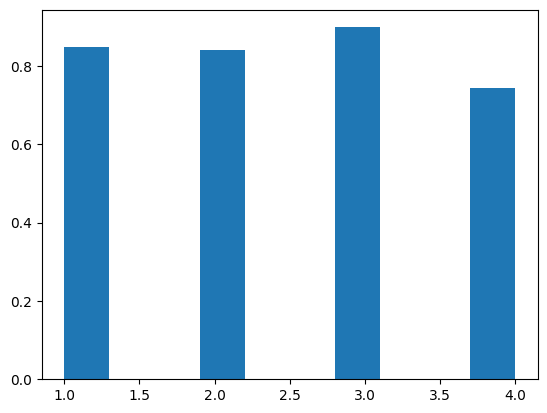

In [37]:
plt.hist(arr_final.flatten(), density=1)